In [ ]:
# ! pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd 

In [ ]:
df = pd.read_excel('MCAP31032023_0.xlsx')
sym_comp = df['Symbol']
sym_comp.dropna(inplace=True)
sym_comp.isna().sum()
tickers = []
tickers.extend(sym_comp.values)

In [ ]:
tcs_test = pd.read_csv('stocksdata_test.csv')
dic = {'year':[],'month':[],'date':[]}
lth = len(tcs_test.Date)
for i in range(lth):
    lst = tcs_test.Date[i].split(sep='-')
    dic['date'].append(lst[2])
    dic['month'].append(lst[1])
    dic['year'].append(lst[0])

dft = pd.DataFrame(dic)
dft.index
tcs_test['Date'] = pd.to_datetime(dft['date'].astype(str)+'-'+dft['month'].astype(str)+'-'+dft['year'].astype(str),dayfirst=True,infer_datetime_format=True) # feature type is not datetime 
print(tcs_test.info())
tcs_test.set_index('Date',inplace=True)
print(tcs_test.head())
tcs_test.tail()

In [ ]:
# df = yf.download(tickers[1],period='6mo')
# f = open('stocksdata.csv','w')
# df.to_csv('stocksdata.csv')
# f.close()
df = pd.read_csv('stocksdata_acc.csv')
df

In [ ]:
dic = {'year':[],'month':[],'date':[]}
lth = len(df.Date)
for i in range(lth):
    lst = df.Date[i].split(sep='-')
    dic['date'].append(lst[2])
    dic['month'].append(lst[1])
    dic['year'].append(lst[0])


In [ ]:
dft = pd.DataFrame(dic)
dft.index

In [ ]:
df['Date'] = pd.to_datetime(dft['date'].astype(str)+'-'+dft['month'].astype(str)+'-'+dft['year'].astype(str),dayfirst=True,infer_datetime_format=True) # feature type is not datetime 
print(df.info())

## __Time_Series_Analysis__

In [ ]:
df.set_index('Date',inplace=True)
print(df.head())
df.tail()

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(data=df,x=df.index,y=df['Close'])
plt.show()

In [ ]:
# calcaulate the plot of rolling mean and standard deviation
df['rollMean'] = df['Close'].rolling(window=20).mean() ## window = 12 parameter shiftes the time by 12 column
df['rollStd'] = df['Close'].rolling(window=20).std()

In [ ]:
print(df['rollMean'])
print(df['rollStd']) # it will take rolling mean after first 12 values

In [ ]:
df.head(5)

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df,x=df.index,y=df['Close'])
sns.lineplot(data=df,x=df.index,y=df['rollMean'])
sns.lineplot(data=df,x=df.index,y=df['rollStd'])
plt.show()

In [ ]:
# conclusion : Mean is not stationary , SD is not stationary; so our data is not stationary
# Now let us perform the ADF test 

In [ ]:
from statsmodels.tsa.stattools import adfuller
adfTest = adfuller(df['Close'])
adfTest
# Interpret these value below by converting into series

In [ ]:
stats = pd.Series(adfTest[0:4],index=['Test Statistics','p-value','#lags used','number of observation'])
stats

In [ ]:
for key, values in adfTest[4].items():
    print('critically',key,':',values)

In [ ]:
def test_stationary(df,var):
    df['rollMean'] = df[var].rolling(window=12).mean() ## window = 12 parameter shiftes the time by 12 column
    df['rollStd'] = df[var].rolling(window=12).std()
    from statsmodels.tsa.stattools import adfuller
    adfTest = adfuller(df[var])
    stats = pd.Series(adfTest[0:4],index=['Test Statistics','p-value','#lags used','number of observation'])
    print(stats)
    for key, values in adfTest[4].items():
        print('critically',key,':',values)
    plt.figure(figsize=(10,5))
    sns.lineplot(data=df,x=df.index,y=var)
    sns.lineplot(data=df,x=df.index,y='rollMean')
    sns.lineplot(data=df,x=df.index,y='rollStd')
    plt.show()

In [ ]:
test_stationary(df,'Close')

In [ ]:
tcs_df = df[['Close']].copy() # double bracket cuz its list within a list
tcs_df.head()

In [ ]:
def shift(x):
    tcs_df = df[['Close']].copy()
    tcs_df['shift'] = tcs_df.Close.shift(x) # create a new column which will contain shifted value from Close 
    tcs_df['shiftDiff'] = tcs_df['Close'] - tcs_df['shift']
    # print(tcs_df.sample(20))
    shifted_Data = tcs_df.dropna()
    return shifted_Data

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df,x=df.index,y=df['Close'])
sns.lineplot(data=df,x=df.index,y=df['rollMean'])
sns.lineplot(data=df,x=df.index,y=df['rollStd'])
plt.show()

In [ ]:
shifted_Data = shift(1)
test_stationary(shifted_Data,'shiftDiff')

# Interpret these value below by converting into series

### __ARIMA__

In [ ]:
tcs = df[['Close']].copy(deep=True)
tcs['FirstDiff'] = tcs[['Close']].diff(1) # for ARIMA
#tcs['FirstDiff'] = tcs[['Close']].diff(12) # for

In [ ]:
print(tcs.head())

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [ ]:
plot_pacf(tcs['FirstDiff'].dropna(),lags=20)
plt.show()

* the shaded area is insignificant area
* PACF gives us the auto regressive values
* frist 'p' is 1 (the axis co-ordinate), whoes value is ~0.31 (the y-axis co-ordinate)
* so, significant P values are 1 ,2 ,3, 4, etc  

In [ ]:
plot_acf(tcs['FirstDiff'].dropna(),lags=20)

In [ ]:
tcs.sort_index()

In [ ]:
import itertools
p=d=q=range(5)
pdq = list(itertools.product(p,d,q))
lst = {}
for param in pdq:
    try:
        model_arima = ARIMA(tcs['Close'],order=param)
        model_arima_fit = model_arima.fit()
        lst[param] = model_arima_fit.aic
    except:
        continue
x = 0
pdq = 0
for k in lst.keys():
    if x > lst[k]:
        x = lst[k]
        pdq = k

In [ ]:
model = ARIMA(tcs['Close'],order=pdq) # Parameters: p, d, q
model_fit = model.fit()
# prediction = model_fit.predict(start=test.index[0],end=test.index[-1], freq = None)
prediction = model_fit.get_forecast(steps = 30 , exog = df.iloc[-30:]['Close'])
tcs['arimaPred'] = prediction
print(tcs.tail())

# Plot

sns.lineplot(data=tcs,x=tcs.index,y='Close')
# sns.lineplot(data=tcs,x=tcs.index,y='arimaPred')
plt.plot(pd.date_range(start = df.index[-1],periods = 30 , freq = 'd'),prediction.predicted_mean , label = "test",color = 'Green')
plt.show()

# Conclusion: The ARIMA prediction is not good



In [ ]:
# test.Date['2022-11-11']

In [ ]:
tcs = df[['Close']].copy(deep=True)
print(tcs.head())

# Create columns for one month and one year lagged data
tcs['firstDiff'] = tcs['Close'].diff()
tcs['Diff12'] = tcs['Close'].diff(5) # This will show nulls to start with

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(tcs['Diff12'].dropna(),lags=10)
plt.show() 

plot_acf(tcs['Diff12'].dropna(),lags=10)
plt.show()

In [104]:
train = tcs[:round(len(tcs)*70/100)] # Take the first 70% data
test = tcs[round(len(tcs)*70/100):] # Take the last 30% data, starting from 71%

# First ARIMA prediction
# model = ARIMA(train['Clorediction = model_fit.predict(start=test.index[0],end=test.index[-1])
# tcs['sarimaxPred'] = prediction
# print(tcs.tail()),order=(3,1,3)) # Parameters: p, d, q
# model_fit = model.fit()
# prediction = model_fit.predict(start=test.index[0],end=test.index[-1])
# tcs['arimaPred'] = prediction

# Now SARIMAX prediction
model = SARIMAX(train['Close'],order=pdq , seasonal_order=(1,1,1,20))
model_fit = model.fit()
# prediction = model_fit.predict(start=test.index[1],end=test.index[-1])
prediction = model_fit.get_forecast(steps = 30 , exog = df.iloc[-30:]['Close'])
tcs['sarimaxPred'] = prediction
print(tcs.tail())


c:\Users\q\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\q\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\q\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            Close  firstDiff  Diff12  \
Date                                   
2023-03-24   3.34      -0.01    0.02   
2023-03-27   3.31      -0.03   -0.15   
2023-03-28   3.25      -0.06   -0.23   
2023-03-29   3.29       0.04   -0.09   
2023-03-30   3.29       0.00   -0.06   

                                                  sarimaxPred  
Date                                                           
2023-03-24  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2023-03-27  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2023-03-28  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2023-03-29  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2023-03-30  <statsmodels.tsa.statespace.mlemodel.Predictio...  


c:\Users\q\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\q\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [105]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                  191
Model:             SARIMAX(2, 1, 2)x(1, 2, [1], 20)   Log Likelihood                 -57.449
Date:                              Tue, 10 Oct 2023   AIC                            128.897
Time:                                      00:24:35   BIC                            149.972
Sample:                                           0   HQIC                           137.459
                                              - 191                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6942      0.029     57.657      0.000       1.637       1.752
ar.L2         -0.9561      0.028    -33.704      0.000      -1.012      -0.901
ma.L1         -1.7722      0.172    -10.295      0.000      -2.110      -1.435
ma.L2          0.9955      0.194      5.128      0.000       0.615       1.376
ar.S.L20      -0.3717      0.089     -4.197      0.000      -0.545      -0.198
ma.S.L20      -0.9992     57.312     -0.017      0.986    -113.329     111.331
sigma2         0.0852      4.877      0.017      0.986      -9.474       9.644
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):                 0.54
Prob(Q):                              0.45   Prob(JB):                         0.76
Heteroskedasticity (H):               0.59   Skew:                            -0.08
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [106]:
tcs

,Close,firstDiff,Diff12,sarimaxPred
Date,,,,
2022-03-01,8.64,NaN,NaN,<statsmodels.tsa.statespace.mlemodel.Predictio...
2022-03-02,8.59,-0.050000,NaN,<statsmodels.tsa.statespace.mlemodel.Predictio...
2022-03-03,8.72,0.130000,NaN,<statsmodels.tsa.statespace.mlemodel.Predictio...
2022-03-04,8.35,-0.370000,NaN,<statsmodels.tsa.statespace.mlemodel.Predictio...
2022-03-07,7.99,-0.360001,NaN,<statsmodels.tsa.statespace.mlemodel.Predictio...
...,...,...,...,...
2023-03-24,3.34,-0.010000,0.02,<statsmodels.tsa.statespace.mlemodel.Predictio...
2023-03-27,3.31,-0.030000,-0.15,<statsmodels.tsa.statespace.mlemodel.Predictio...
2023-03-28,3.25,-0.060000,-0.23,<statsmodels.tsa.statespace.mlemodel.Predictio...


            Close  firstDiff  Diff12  \
Date                                   
2022-03-01   8.64        NaN     NaN   
2022-03-02   8.59  -0.050000     NaN   
2022-03-03   8.72   0.130000     NaN   
2022-03-04   8.35  -0.370000     NaN   
2022-03-07   7.99  -0.360001     NaN   

                                                  sarimaxPred  
Date                                                           
2022-03-01  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2022-03-02  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2022-03-03  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2022-03-04  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2022-03-07  <statsmodels.tsa.statespace.mlemodel.Predictio...  


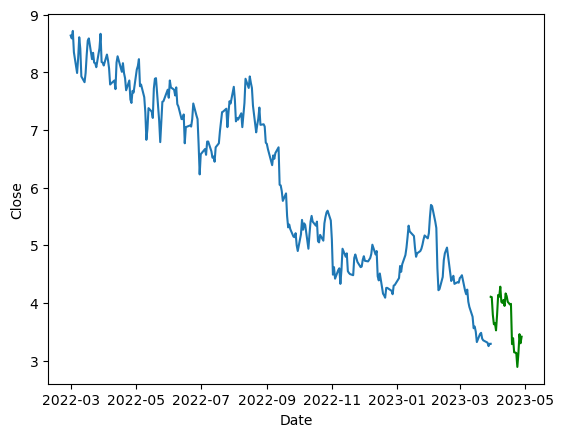

In [107]:
# Data looks better

# Plot
tcs.dropna()
print(tcs.head())
sns.lineplot(data=tcs,x=tcs.index,y='Close')
plt.plot(pd.date_range(start = df.index[-1],periods = 30 , freq = 'd'),prediction.predicted_mean , label = "test",color = 'Green')
# sns.lineplot(data=tcs,x=tcs.index,y='sarimaxPred')
# sns.lineplot(data=tcs,x=tcs.index,y='arimaPred')
plt.show()

In [108]:
# Compared to ARIMA, SARIMAX is much better

# Future prediction

# First check the last date in our dataset
print(tcs.tail())

# MS: Month Start frequency
# Create a data frame to hold index values from 01.01.61 to 01.12.62
futureDate = pd.DataFrame(pd.date_range(start='2023-01-07', end='2023-10-09',freq='D'),columns=['Dates'])
# futureDate.set_index('Dates',inplace=True)
print(futureDate.head())

# Predict and print
predict = model_fit.predict(start=futureDate.index[0],end=futureDate.index[-1])
print(predict)

            Close  firstDiff  Diff12  \
Date                                   
2023-03-24   3.34      -0.01    0.02   
2023-03-27   3.31      -0.03   -0.15   
2023-03-28   3.25      -0.06   -0.23   
2023-03-29   3.29       0.04   -0.09   
2023-03-30   3.29       0.00   -0.06   

                                                  sarimaxPred  
Date                                                           
2023-03-24  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2023-03-27  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2023-03-28  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2023-03-29  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2023-03-30  <statsmodels.tsa.statespace.mlemodel.Predictio...  
       Dates
0 2023-01-07
1 2023-01-08
2 2023-01-09
3 2023-01-10
4 2023-01-11
0      0.000000
1      8.640000
2      8.590000
3      8.720000
4      8.350000
         ...   
271    0.930840
272    0.933551
273    0.587145
274    0.602037
275    0.608246
Name: predicted_m

c:\Users\q\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\q\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


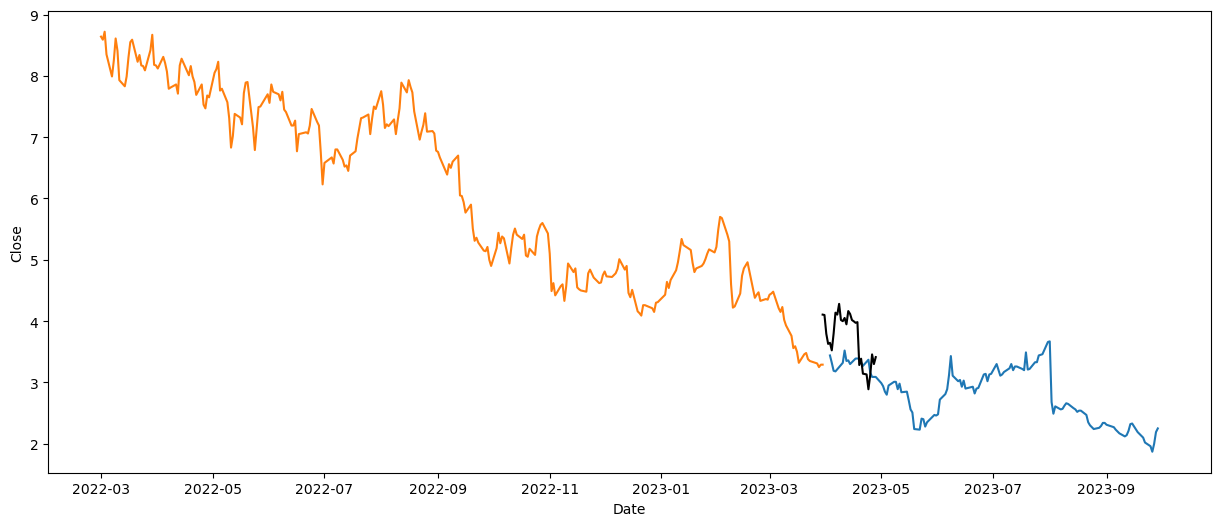

In [109]:

# Plot

tcs.dropna()
plt.figure(figsize=(15,6))
sns.lineplot(data=tcs_test,x=tcs_test.index,y='Close')
sns.lineplot(data=tcs,x=tcs.index,y='Close')
plt.plot(pd.date_range(start = tcs.index[-1],periods = 30 , freq = 'd'),prediction.predicted_mean , label = "test",color = 'Black')
# sns.lineplot(data=tcs,x=tcs.index,y='arimaPred')
# model_fit.predict(start=futureDate.index[0],end=futureDate.index[-1],step = 30).plot(color='black')
plt.show()
